In [0]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import pandas as pd
from pyspark.sql.types import (ArrayType, LongType, StringType, StructField, StructType, DoubleType, MapType)
import matplotlib.pyplot as plt
from plotnine import *
import plotnine as p9
import numpy as np

In [0]:
%sql
USE DATABASE monthly_all; 

In [0]:
df = sqlContext.sql("""
SELECT 
t.ticker, m.location_name, m.region, t.quarter_num, t.year, t.revenue, t.reported_eps, t.estimated_eps, t.eps_surprise_percentage, t.eps_beat_expectations, m.raw_visit_counts, m.raw_visitor_counts, m.visits_by_day, m.distance_from_home, m.median_dwell, m.normalized_visits_by_state_scaling, c.naics_code, m.date_range_start, m.date_range_end, m.normalized_visits_by_total_visits, m.normalized_visits_by_total_visitors 
FROM ( SELECT * , ADD_MONTHS(quarter_end, -3) AS quarter_begin FROM targets ) AS t 
LEFT JOIN sg_tickers s 
  ON s.stock_symbol = t.ticker 
LEFT JOIN core_places c 
  ON c.brand = s.safegraph_brand_id 
LEFT JOIN monthly_patterns m 
  ON m.placekey = c.placekey AND m.date_range_end BETWEEN t.quarter_begin AND t.quarter_end
""")

df = df.na.drop(subset=["ticker", "quarter_num", "year"])
df.repartition(64).write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("vikings.base")                   

### Keyanna's Code

In [0]:
k_df = df.select('ticker', 'quarter_num', 'year', 'location_name', 'region', 'raw_visit_counts', 'raw_visitor_counts', 'distance_from_home', 'median_dwell', 'revenue', 'eps_beat_expectations')

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1383174821531638> in <module> 
 ----> 1 k_df = df . select ( 'ticker' , 'quarter_num' , 'year' , 'location_name' , 'region' , 'raw_visit_counts' , 'raw_visitor_counts' , 'distance_from_home' , 'median_dwell' , 'revenue' , 'eps_beat_expectations' ) 

 NameError : name 'df' is not defined

In [0]:
k_df = k_df.withColumn("distance_from_home", F.when(k_df["distance_from_home"] > 250000, 250000).otherwise(k_df["distance_from_home"]))
k_df = k_df.withColumn("Distance_By_Time", k_df.distance_from_home / k_df.median_dwell)
k_df = k_df.select("*",F.round("Distance_By_Time",2))
k_df = k_df.drop("Distance_By_Time")
k_df = k_df.withColumnRenamed("round(Distance_By_Time, 2)", "Distance_By_Time")

k_df = k_df.withColumn("Percent_Repeat_Visits", (k_df.raw_visit_counts - k_df.raw_visitor_counts) / k_df.raw_visit_counts)
k_df = k_df.select("*",F.round("Percent_Repeat_Visits",2))
k_df = k_df.drop("Percent_Repeat_Visits")
k_df = k_df.withColumnRenamed("round(Percent_Repeat_Visits, 2)", "Percent_Repeat_Visits")

k_df = k_df.withColumn("Repeat_Visits_Distance_By_Time", k_df.Distance_By_Time * k_df.Percent_Repeat_Visits)
k_df = k_df.select("*",F.round("Repeat_Visits_Distance_By_Time",2))
k_df = k_df.drop("Repeat_Visits_Distance_By_Time")
k_df = k_df.withColumnRenamed("round(Repeat_Visits_Distance_By_Time, 2)", "Repeat_Visits_Distance_By_Time")
k_df = k_df.withColumn("Repeat_Visits_Distance_By_Time", F.when(k_df.Repeat_Visits_Distance_By_Time == '0',k_df.Distance_By_Time) \
      .otherwise(k_df.Repeat_Visits_Distance_By_Time))
### Saves this table to make the rest of the code run faster
k_df.repartition(64).write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("vikings.RVDBT")

In [0]:
###Group by to narrow down to 1 unique ticker, quarter, year with aggregated features
k_df1 = k_df.groupBy("ticker","quarter_num", "year").agg(F.round(F.avg("Repeat_Visits_Distance_By_Time"),2),F.round(F.stddev("Repeat_Visits_Distance_By_Time"),2),F.round(F.avg("raw_visit_counts"),2))
k_df1 = k_df1.withColumnRenamed("round(avg(Repeat_Visits_Distance_By_Time), 2)", "Avg_RVDBT")
k_df1 = k_df1.withColumnRenamed("round(stddev_samp(Repeat_Visits_Distance_By_Time), 2)", "Stddev_RVDBT")
k_df1 = k_df1.withColumnRenamed("round(avg(raw_visit_counts), 2)", "Average_Raw_Visit_Counts")

k_df2 = k_df.join(k_df1, ["ticker", "quarter_num", "year"])
###Window Function to calculate the percent change in raw visit counts
windowSpec = Window.partitionBy('ticker').orderBy("year","quarter_num")
k_df2 = k_df2.withColumn('RVC_Percent_Change', F.round((k_df2.Average_Raw_Visit_Counts - F.lag(k_df2['Average_Raw_Visit_Counts']).over(windowSpec))/100, 4)).sort(F.asc("ticker"), F.asc("year"), F.asc("quarter_num"))
k_df2 = k_df2.na.fill(value=0,subset=["RVC_Percent_Change"])
k_df2 = k_df2.withColumn("RCVPC_RVDBT", F.when(k_df2.RVC_Percent_Change == '0', k_df2.Repeat_Visits_Distance_By_Time) \
      .otherwise(k_df2.Repeat_Visits_Distance_By_Time * k_df2.RVC_Percent_Change))
k_df2 = k_df2.select('ticker', 'quarter_num', 'year', 'Avg_RVDBT', 'Stddev_RVDBT', 'RVC_Percent_Change','RCVPC_RVDBT', 'revenue', 'eps_beat_expectations')
### Saves the table
k_df2.repartition(64).write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("model.aggRVDBT")

In [0]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
k_df3 = k_df2.select("*").toPandas()

In [0]:
k_df3['eps_beat_expectations'] = k_df3['eps_beat_expectations'].apply(str)
### For graphing purposes I'm going to drop some rows here
k_df3 = k_df3.loc[k_df3["RVC_Percent_Change"] != 0 ]
k_df3 = k_df3.loc[k_df3['eps_beat_expectations'] != 'nan']

Out[99]:

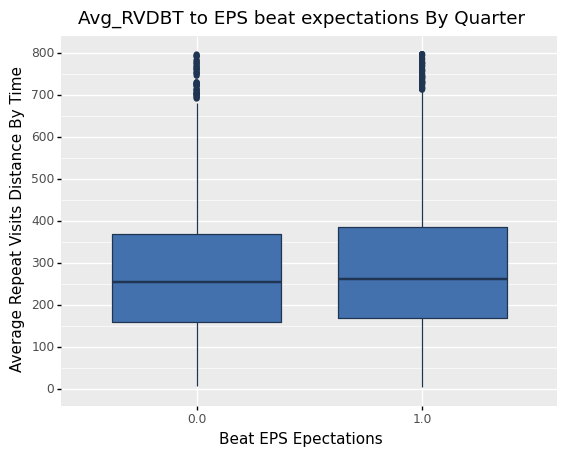

<ggplot: (8780217921259)>

In [0]:
avg_rvdbt = (
    ggplot(k_df3, aes("eps_beat_expectations", "Avg_RVDBT"))
    + geom_boxplot(colour="#1F3552", fill="#4271AE")
    + xlab("Beat EPS Epectations")
    + ylab("Average Repeat Visits Distance By Time")
    + scale_y_continuous(breaks=np.arange(0, 801, 100), limits=[0, 800])
    + ggtitle("Avg_RVDBT to EPS beat expectations By Quarter")
)
avg_rvdbt

Out[100]:

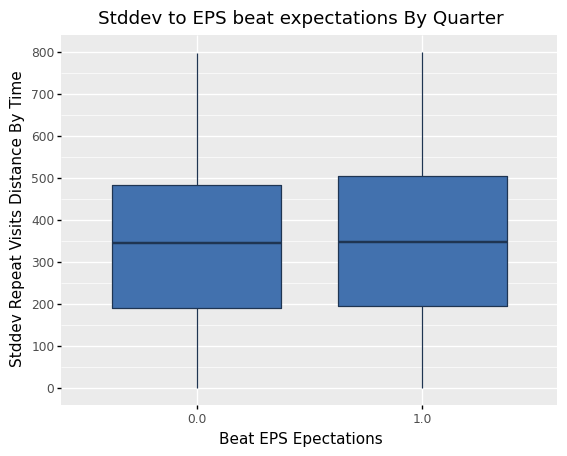

<ggplot: (8780398299901)>

In [0]:
stddev_rvdbt = (
    ggplot(k_df3, aes("eps_beat_expectations", "Stddev_RVDBT"))
    + geom_boxplot(colour="#1F3552", fill="#4271AE")
    + xlab("Beat EPS Epectations")
    + ylab("Stddev Repeat Visits Distance By Time")
    + scale_y_continuous(breaks=np.arange(0, 801, 100), limits=[0, 800])
    + ggtitle("Stddev to EPS beat expectations By Quarter")
)
stddev_rvdbt

Out[101]:

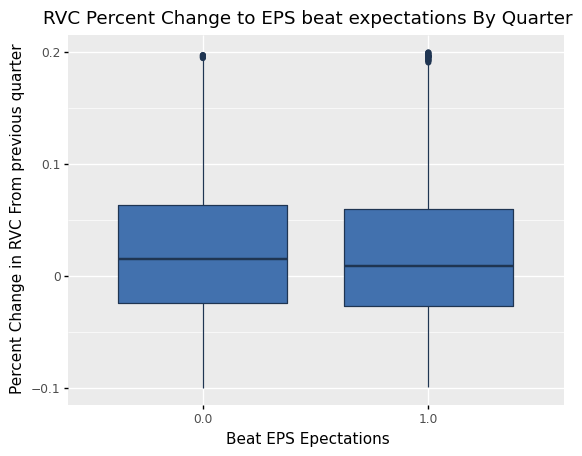

<ggplot: (8780426702939)>

In [0]:
percent_change = (
    ggplot(k_df3, aes("eps_beat_expectations", "RVC_Percent_Change"))
    + geom_boxplot(colour="#1F3552", fill="#4271AE")
    + xlab("Beat EPS Epectations")
    + ylab("Percent Change in RVC From previous quarter")
    + scale_y_continuous(breaks=np.arange(-0.1, 0.2, 0.10), limits=[-0.1, 0.2])
    + ggtitle("RVC Percent Change to EPS beat expectations By Quarter")
)
percent_change

Out[109]:

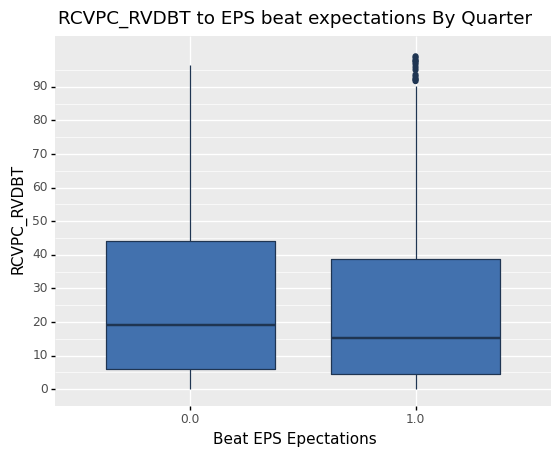

<ggplot: (8780344123191)>

In [0]:
RCVPC_RVDBT = (
    ggplot(k_df3, aes("eps_beat_expectations", "RCVPC_RVDBT"))
    + geom_boxplot(colour="#1F3552", fill="#4271AE")
    + xlab("Beat EPS Epectations")
    + ylab("RCVPC_RVDBT")
    + scale_y_continuous(breaks=np.arange(0, 100, 10), limits=[0, 100])
    + ggtitle("RCVPC_RVDBT to EPS beat expectations By Quarter")
)
RCVPC_RVDBT

### Asher's Code

In [0]:
dat = sqlContext.sql("""
SELECT 
t.ticker, t.quarter_num, t.year, m.date_range_start, m.visits_by_day, m.raw_visit_counts, m.normalized_visits_by_state_scaling, t.revenue, t.reported_eps, t.estimated_eps, t.eps_surprise_percentage, t.eps_beat_expectations 
FROM monthly_all.monthly_patterns m 
LEFT JOIN monthly_all.core_places c 
  ON m.placekey = c.placekey 
LEFT JOIN monthly_all.sg_tickers s 
  ON c.brand = s.safegraph_brand_id  
LEFT JOIN ( SELECT *, ADD_MONTHS(quarter_end, -3) AS quarter_begin FROM monthly_all.targets ) as t 
  ON s.stock_symbol = t.ticker AND m.date_range_end 
  BETWEEN t.quarter_begin AND t.quarter_end AND m.date_range_start BETWEEN t.quarter_begin AND t.quarter_end""")
from pyspark.sql.functions import to_timestamp,date_format

a_df=dat.na.drop(subset=["ticker"]).select("ticker","quarter_num","year","date_range_start","visits_by_day","raw_visit_counts","normalized_visits_by_state_scaling","revenue","reported_eps","estimated_eps","eps_surprise_percentage","eps_beat_expectations")

a_df = a_df.orderBy("ticker","year","quarter_num")
a_df = a_df.withColumn("New_Date",F.to_date("date_range_start")).withColumn('Month',date_format(F.col("New_Date"),"M")).drop_duplicates()

g1 =Window.partitionBy("ticker","year","quarter_num")

a_df = a_df.withColumn("Max",F.array_max(dat.visits_by_day))
a_df = a_df.withColumn("Avg_Max", F.avg("Max").over(g1)).select("ticker","quarter_num","year","raw_visit_counts","normalized_visits_by_state_scaling","Avg_Max","revenue","reported_eps","estimated_eps","eps_surprise_percentage","eps_beat_expectations")

a_df = a_df.withColumn("math", (F.col("Avg_Max")/F.col("raw_visit_counts"))*F.col("normalized_visits_by_state_scaling"))
a_df = a_df.withColumn("Feature", F.avg("math").over(g1)).select("ticker","year","quarter_num","Feature","revenue","reported_eps","estimated_eps","eps_surprise_percentage","eps_beat_expectations")
a_Final = a_df.dropDuplicates(['ticker', 'year','quarter_num'])

In [0]:
a_Final.display()

ticker,year,quarter_num,Feature,revenue,reported_eps,estimated_eps,eps_surprise_percentage,eps_beat_expectations
AHCO,2019,1,64.74250724640073,1.11116492E8,0.0264,null,null,null
AMNB,2021,4,18.580997174092168,2.953E7,1.05,0.8,31.25,1
ASB,2021,4,68.77228820553849,2.68265E8,0.49,0.42,16.6667,1
AUB,2021,3,87.15767620183301,1.86276E8,0.94,0.768,22.3958,1
AZO,2021,3,245.170891747779,4.913484E9,35.72,29.883,19.5328,1
BANR,2020,3,73.34336818965386,1.37398E8,1.0373,0.83,24.9759,1
BBBY,2020,2,131.66487306602315,1.305492E9,-1.96,-1.3167,-48.857,0
BBBY,2020,4,249.21306802403913,2.504181E9,0.08,0.2002,-60.04,0
BKD,2021,2,117.64405297647681,6.68781E8,-0.4361,-0.52,16.1346,1
BKE,2022,1,523.7221996281854,3.8093E8,1.69,1.44,17.3611,1


In [0]:
a_WMT = a_Final.filter(a_Final.ticker == "WMT")
a_W = a_WMT.select("*").toPandas()

Out[103]:

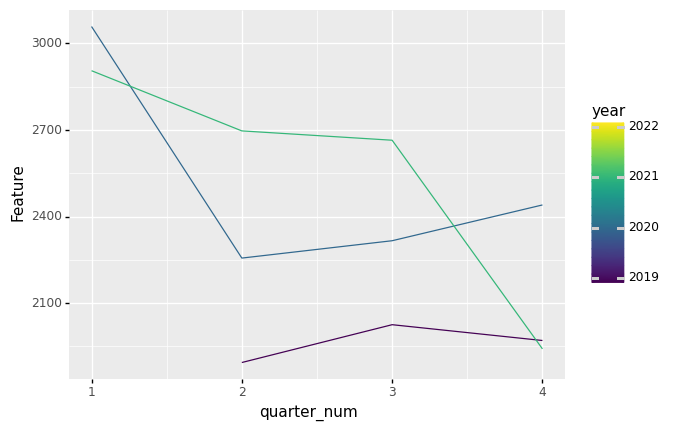

<ggplot: (8778360967434)>

In [0]:
p9.ggplot(data = a_W,
         mapping=p9.aes(x="quarter_num",
                       y="Feature",
                       group = "year",
                       color = "year"))+p9.geom_line()

Out[104]:

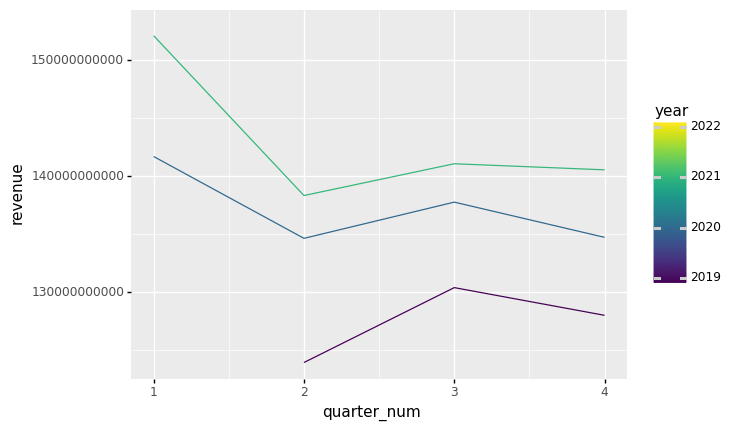

<ggplot: (8778361123133)>

In [0]:
p9.ggplot(data = a_W,
         mapping=p9.aes(x="quarter_num",
                       y="revenue",
                       group = "year",
                       color = "year"))+p9.geom_line()

### Brigham's Code

In [0]:
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark import SparkContext, SQLContext
import pyspark.sql.functions as F
from pyspark.sql import Window
 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
%sql 
USE DATABASE monthly_all; 

In [0]:
brigham_2 = spark.sql("""
SELECT 
t.ticker, t.quarter_num, t.year, m.raw_visit_counts, m.raw_visitor_counts, t.revenue, t.reported_eps, t.estimated_eps, t.eps_surprise_percentage, t.eps_beat_expectations 
FROM ( SELECT *, ADD_MONTHS(quarter_end, -3) AS quarter_begin FROM targets ) AS t
LEFT JOIN sg_tickers s
  ON s.stock_symbol = t.ticker
LEFT JOIN core_places c
  ON c.brand = s.safegraph_brand_id
LEFT JOIN monthly_patterns m
  ON m.placekey = c.placekey
  AND m.date_range_end BETWEEN t.quarter_begin AND t.quarter_end
WHERE m.raw_visit_counts is not null 
""")

brigham_2.display()
brigham_2.repartition(64).write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("vikings.brigham_z_scores") 

ticker,quarter_num,year,raw_visit_counts,raw_visitor_counts,revenue,reported_eps,estimated_eps,eps_surprise_percentage,eps_beat_expectations
CVX,1,2022,542,280,5.4373E10,3.36,3.27,2.7523,1
CVX,1,2022,471,251,5.4373E10,3.36,3.27,2.7523,1
CVX,1,2022,543,266,5.4373E10,3.36,3.27,2.7523,1
CVX,4,2021,633,315,4.8129E10,2.56,3.12,-17.9487,0
CVX,4,2021,606,292,4.8129E10,2.56,3.12,-17.9487,0
CVX,4,2021,553,278,4.8129E10,2.56,3.12,-17.9487,0
CVX,3,2021,875,464,4.471E10,2.96,2.1919,35.0427,1
CVX,3,2021,723,387,4.471E10,2.96,2.1919,35.0427,1
CVX,3,2021,680,363,4.471E10,2.96,2.1919,35.0427,1
CVX,2,2021,488,253,3.7597E10,1.71,1.6047,6.562,1


In [0]:
window_1 = Window.partitionBy("ticker")

graph_dat = (brigham_2       
      .withColumn("numerator1", F.col("raw_visit_counts") - F.mean("raw_visit_counts").over(window_1))
      .withColumn("denominator1", F.stddev("raw_visit_counts").over(window_1))
      .withColumn("z_score_raw_visits", F.col("numerator1") / F.col("denominator1") ) 
       
      .withColumn("numerator2", F.col("raw_visitor_counts") - F.mean("raw_visitor_counts").over(window_1))
      .withColumn("denominator2", F.stddev("raw_visitor_counts").over(window_1))
      .withColumn("z_score_raw_visitors", F.col("numerator2") / F.col("denominator2") ) 
      
      .select("ticker", "quarter_num", "year", "revenue", "reported_eps", "estimated_eps", "eps_surprise_percentage", "eps_beat_expectations", "z_score_raw_visits", "z_score_raw_visitors")
      .drop_duplicates(["ticker", "quarter_num", "year"])
      .orderBy("ticker", "quarter_num", "year")
      .toPandas()
)

graph_dat.display()
# graph_dat = graph_dat.select("*").toPandas()


ticker,quarter_num,year,revenue,reported_eps,estimated_eps,eps_surprise_percentage,eps_beat_expectations,z_score_raw_visits,z_score_raw_visitors
AA,1,2022,3.255E9,3.06,2.93,4.4369,1.0,1.1547005383792515,1.154700538379251
AAN,1,2019,4.80056E8,1.08,0.94,14.8936,1.0,-0.08947425298449371,0.11276592365541108
AAN,1,2020,4.32831E8,0.85,0.78,8.9744,1.0,0.21069392578899612,0.3147272054547854
AAN,1,2021,4.81054E8,1.24,0.565,119.469,1.0,-0.26457235726902945,-0.1295876145038381
AAN,1,2022,4.56082E8,0.87,0.68,27.9412,1.0,-0.464684476451356,-0.4325295372028996
AAN,2,2019,4.43198E8,0.93,0.87,6.8966,1.0,-0.17702330512676157,-0.02860697360415095
AAN,2,2020,4.30955E8,1.18,0.78,51.2821,1.0,-0.37713542430908814,-0.35174502448314987
AAN,2,2021,4.67495E8,1.05,0.6589,59.3565,1.0,-0.464684476451356,-0.4325295372028996
AAN,3,2019,4.26271E8,0.73,0.82,-10.9756,0.0,-0.16451629767786616,0.011785282755723917
AAN,3,2020,4.40961E8,1.8,1.44,25.0,1.0,0.04810282895335579,0.3147272054547854


Out[94]: /databricks/python/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 40 rows containing missing values.

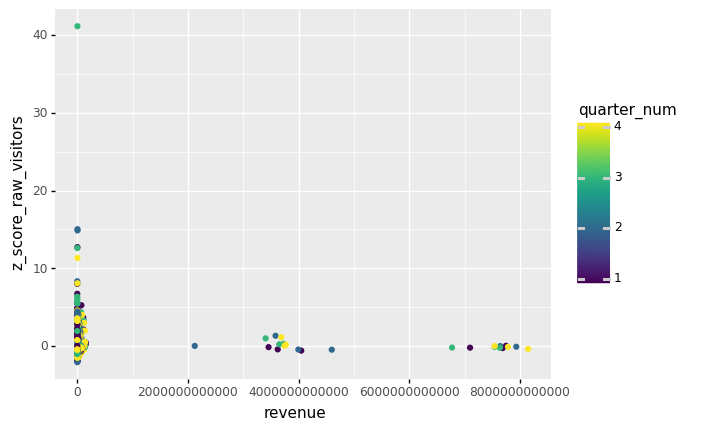

<ggplot: (8778360519409)>

In [0]:
z_score_raw_visitors_plot = (
p9.ggplot(data = graph_dat)+
  p9.geom_point(mapping = p9.aes(x="revenue", y="z_score_raw_visitors", color = "quarter_num"))
)
z_score_raw_visitors_plot

Out[95]: /databricks/python/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 486 rows containing non-finite values.

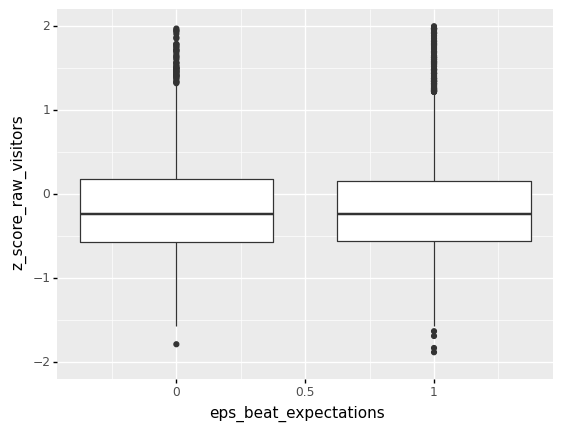

<ggplot: (8778359874479)>

In [0]:
z_score_raw_visitors_plot = (
p9.ggplot(data = graph_dat)+
  p9.geom_boxplot(mapping = p9.aes(x="eps_beat_expectations", y="z_score_raw_visitors", color = "quarter_num", group = "eps_beat_expectations"))+
  ylim(-2,2)
)
z_score_raw_visitors_plot